# Import libraries

In [1]:
# verify packages are present will present an error if you are missing dependencies
import scipy
import pandas as pd
import numpy as np
import itertools
from random import shuffle
import random
from scipy import stats, optimize
from skbio import DistanceMatrix
from skbio.stats.ordination import PCoA
from __future__ import division
from skbio.stats.distance import pwmantel
from skbio.diversity.beta import pw_distances
from skbio.stats.distance import bioenv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skbio.stats.distance import ANOSIM
import brewer2mpl
from skbio.stats.spatial import procrustes 
import seaborn as sns
import pylab
import matplotlib
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.svm import SVC
from sklearn import cross_validation
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from IPython.display import display, HTML
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from biom import load_table
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py

/home/cameron/anaconda2/envs/RPCA_env/lib/python2.7/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


Installed autotime.py. To use it, type:
  %load_ext autotime


In [2]:
%load_ext autotime
%matplotlib inline

# Run the following cell twice


In [3]:
%load r_pca/r_pca.py

time: 65.7 ms


### Sources:


Emmanuel J. Candès , Xiaodong Li , Yi Ma , John Wright, Robust principal component analysis?, Journal of the ACM (JACM), v.58 n.3, p.1-37, May 2011 http://statweb.stanford.edu/~candes/papers/RobustPCA.pdf

Papanicolaou Alex, RPCA, (2011), GitHub repository, https://github.com/apapanico/RPCA


# Define functions

In [4]:
def convert_biom_to_pandas(table):
    """ Unpacks biom table into two pandas dataframes.
    
    The first dataframe will contain the count information for 
    features and samples. The second datafram will contain taxonomy 
    information for all of the OTUs.
    
    Parameters
    ----------
    table : biom.Table
    
    Returns
    -------
    pd.DataFrame
        Contingency table of counts where samples correspond 
        to rows and columns correspond to features (i.e. OTUs)
    pd.DataFrame
        A mapping of OTU names to taxonomic ids
    """

    feature_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                             index=table.ids(axis='sample'),
                             columns=table.ids(axis='observation'))
    feature_ids = table.ids(axis='observation')
    mapping = {i: table.metadata(id=i, axis='observation')['taxonomy'] for i in feature_ids}
    # modify below as necessary.  
    # There are typically 7 levels of taxonomy.
    taxonomy = pd.DataFrame(mapping, 
                            index=['kingdom', 'phylum', 'class', 'order', 
                                   'family', 'genus', 'species']).T
    return feature_table, taxonomy

time: 117 ms


### Source:

Biom to pandas dataframe code:

Jamie Morton, gneiss, (2016), GitHub repository, https://github.com/biocore/gneiss

In [5]:
def scatter_3d(ord_results, df, column, color_map, axis1=0,axis2=1, axis3=2):
    
    Y=df['pH'].tolist()
    coord_matrix = ord_results.site.T
    ids = ord_results.site_ids
    #fig = plt.figure()
    fig = plt.figure(1, figsize=(10, 8))
    #ax = fig.add_subplot(111, projection='3d')
    ax = Axes3D(fig, elev=-135, azim=298)
    xs = coord_matrix[axis1]
    ys = coord_matrix[axis2]
    zs = coord_matrix[axis3]
    plot = ax.scatter(xs, ys, zs, c=Y,cmap=plt.cm.cool,s=200)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.set_axis_bgcolor('white')
    ax.set_xlabel("1st eigenvector", fontsize=30)
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector", fontsize=30)
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector", fontsize=30)
    ax.w_zaxis.set_ticklabels([])
    
    ax.set_axis_bgcolor('white')

    return fig

time: 109 ms


# Import Metadata and build classifiers from columns of the data 

In [6]:
#sort and build classifier for PCA

start_path=''
df= pd.read_table('data/soil_map.txt', index_col=0)
df.sort(['Description'], ascending = [True], inplace = True)
Y=[]
samplenames = df['SampleID'].tolist()
samplenames = map(str, samplenames)
q=0
destmp='start'
for tmp in samplenames:
    
    if destmp=='start':
        conditiontmp=df['Description'][tmp]
        destmp='stop'
        
    if df['Description'][tmp]!=conditiontmp:
        q+=1
        conditiontmp=df['Description'][tmp]
        
    Y.append(q)

time: 129 ms


/home/cameron/anaconda2/envs/RPCA_env/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


# Import the 88 Soils OTU table


In [7]:

table = load_table('data/88_soils.biom')
otu, taxonomy = convert_biom_to_pandas(table)

otu=otu.T

#add taxa names

taxonomy['fg'] = taxonomy['kingdom'].str.cat(taxonomy['family'])
result = pd.concat([otu, taxonomy], axis=1, join='inner')
otu2 = result.set_index('fg')
otu2 = otu2.drop(['kingdom','phylum','class','order','family','genus','species'], 1)
otu=otu2

# reoder according to classifier Y
otu=otu.T
otu=otu.reindex(samplenames)
otu=otu.T


# only keep OTUs with sum accross columns of 100

otulist = otu.columns.values.tolist()
for nm in otulist:
    if otu[nm].sum() < 1:
        otu.drop(nm, axis=1, inplace=True)

        
df = df.fillna(0)
otu =otu.fillna(0)

# save data and names from data frame

index = otu.index.values.tolist()
data = otu.as_matrix()
ids = otu.columns.values.tolist()
ids = map(str, ids)

#check mapping again 

df=df.reindex(ids)

time: 465 ms


# View the data 

In [8]:
print "\nMetadata (classifiers are columns, sample names in rows) 1:"
display(df.head())
print "\nOTU table (sample names are columns, OTU names in rows) 2:"
HTML(otu.head().to_html())


Metadata (classifiers are columns, sample names in rows) 1:


,BarcodeSequence,LinkerPrimerSequence,SampleID,Description,pH,Annual Season Precipitation,Annual Season Tempature,Carbon to Nitrogen Ratio,Cmin Rate,Elevation,Latitude,Longitude,Slit Clay,Soil Moisture Deficit,Total Organic Carbon,Total Organic Nitrogen
#SampleID,,,,,,,,,,,,,,,,
103.PE5,AGACTGCGTACT,CATGCTGCCTCCCGTAGGAGT,103.PE5,3,3.57,5000,23.0,14.55,25.000,1750,-12.633333,-71.266667,70,-1900.0,93.6,0.0
103.BF2,AATCGTGACTCG,CATGCTGCCTCCCGTAGGAGT,103.BF2,3,3.61,1000,7.8,15.20,8.718,390,41.583333,-80.050000,56,-451.3,95.2,0.0
103.HF2,ACGCAACTGCTA,CATGCTGCCTCCCGTAGGAGT,103.HF2,3,3.98,1100,7.0,20.90,10.001,300,42.500000,-72.166667,38,-483.9,95.5,0.0
103.CF2,ACAGACCACTCA,CATGCTGCCTCCCGTAGGAGT,103.CF2,3,3.63,1300,5.3,19.10,3.000,800,41.933333,-74.350000,28,-858.7,40.6,0.0
103.CF1,ACACTGTTCATG,CATGCTGCCTCCCGTAGGAGT,103.CF1,3,3.92,1300,5.3,13.60,2.266,800,42.158333,-74.258333,49,-858.7,25.6,0.0



OTU table (sample names are columns, OTU names in rows) 2:


,103.PE5,103.BF2,103.HF2,103.CF2,103.CF1,103.CF3,103.PE3,103.PE1,103.PE2,103.PE4,103.CL3,103.PE6,103.BF1,103.HF1,103.TL1,103.TL3,103.HI4,103.LQ1,103.BB1,103.LQ3,103.MP2,103.BB2,103.SN1,103.MP1,103.IE1,103.CO2,103.IT1,103.PE7,103.DF1,103.DF3,103.LQ2,103.IE2,103.SK3,103.IT2,103.SK1,103.BZ1,103.SN3,103.HJ1,103.VC1,103.HJ2,103.AR1,103.SP2,103.VC2,103.AR3,103.CL4,103.CL2,103.CL1,103.TL2,103.SA1,103.CC1,103.AR2,103.KP1,103.GB1,103.HI1,103.SR3,103.SR1,103.HI3,103.SP1,103.SK2,103.CO1,103.CO3,103.DF2,103.HI2,103.MT2,103.MD2,103.GB2,103.GB3,103.CM1,103.RT1,103.MD3,103.MT1,103.JT1,103.SF1,103.KP4,103.SB1,103.KP3,103.BP1,103.CA1,103.SF2,103.CR1,103.SV1,103.CA2,103.GB5,103.SR2,103.MD5,103.MD4,103.RT2,103.SV2,103.SA2
fg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
k__Bacteriaf__Gaiellaceae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
k__Bacteriaf__Streptococcaceae,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
k__Bacteriaf__Sphingobacteriaceae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
k__Bacteriaf__Bradyrhizobiaceae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,3.0
k__Bacteriaf__Nocardioidaceae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


time: 71.4 ms


In [9]:
otu.to_csv('/home/cameron/Desktop/soilotu.csv', sep='\t')

time: 595 ms


# Decompose the data with 43 iterations
#### (pre-determined number based on over and underfitting)

## To view the idea behind this method see the notebook Decomposition_Exsplained

### We will solve the problem below convexly

$M = L_{0} + S_{0}$

$L_{0}$ is a Low-rank matrix

$S_{0}$ is a Sparse spikes noise matrix

In [10]:
rpcadata=np.array(data)
rpca = R_pca(rpcadata)
L, S = rpca.fit(max_iter=48, iter_print=100)
low_rank_matrix = L
sparse_matrix = S

iteration: 1, error: 231.178349172
time: 2.02 s


#### Assume

$M = L_{0} + S_{0}$

$L_{0}$ is a Low-rank matrix

$S_{0}$ is a Sparse spikes noise matrix


Not only can this problem be solved, it can be solved by tractable convex optimization. 


Let $ ||M||_{*} := \sum_{i}σ_{i}(M)$ denote the nuclear norm of the matrix M, 

i.e. the sum of the singular values of M

Let $ ||M||_{1} := \sum_{ij}||M||_{ij}$ denote the 1-norm of M seen as a long vector in R n1×n2

Then it can be shown that the Principal Component Pursuit (PCP) estimate solving


Minimize $ ||L||_{*} + λ||S||_{1}$

Subject to $L + S = M$

It can be shown that this exactly recovers the low-rank $L_{0}$ and the sparse $S_{0}$. Theoretically, this is guaranteed to work even if the rank of $L_{0}$ grows almost linearly in the dimension of the matrix, and the errors in $S_{0}$ are up to a constant fraction of all entries.

#### source


Emmanuel J. Candès , Xiaodong Li , Yi Ma , John Wright, Robust principal component analysis?, Journal of the ACM (JACM), v.58 n.3, p.1-37, May 2011 http://statweb.stanford.edu/~candes/papers/RobustPCA.pdf

Papanicolaou Alex, RPCA, (2011), GitHub repository, https://github.com/apapanico/RPCA


#### This allows you to view the underlying trends in the data

<img src="etc/decomp.png">

# View the decomposition

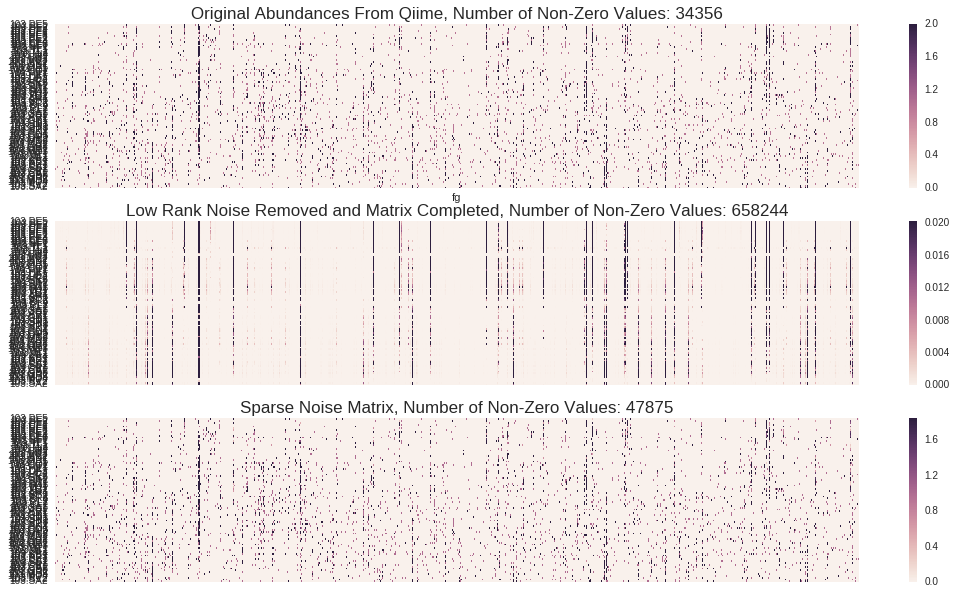

time: 5.12 s


In [11]:
save_lowrankdf = pd.DataFrame(low_rank_matrix,index=index, columns=ids)
save_sparsedf = pd.DataFrame(sparse_matrix, columns=ids)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(18, 10))
sns.heatmap(otu.T, robust=True,xticklabels=False, ax=ax1,vmin=0)
sns.heatmap(save_lowrankdf.T, robust=True,xticklabels=False, ax=ax2,vmin=0)
sns.heatmap(save_sparsedf.T, robust=True,xticklabels=False, ax=ax3,vmin=0)
ax1.set_yticklabels(ax1.yaxis.get_majorticklabels(), rotation=360)
ax2.set_yticklabels(ax2.yaxis.get_majorticklabels(), rotation=360)
ax3.set_yticklabels(ax3.yaxis.get_majorticklabels(), rotation=360)
ax1.set_title('Original Abundances From Qiime, Number of Non-Zero Values: %i'%np.count_nonzero(otu), fontsize=17)
ax2.set_title('Low Rank Noise Removed and Matrix Completed, Number of Non-Zero Values: %i'%np.count_nonzero(low_rank_matrix), fontsize=17)
ax3.set_title('Sparse Noise Matrix, Number of Non-Zero Values: %i'%np.count_nonzero(sparse_matrix), fontsize=17)
plt.show()

# The high level idea is now that we have obtained our underlying compositional signal from the data we can now determine which classifiers are most relevent based on our microbial composition between samples. We can also determine the bacteria that explain the variance between theese groups and then mapp theese back to the origonal data.

# This is done through machine learning both Supervised and Unsupervised

# Supervised 

<img src="etc/supervised_learning.jpg">


# Perform both methods on both the origonal OTU table and the Low Rank one

# First we will use supervised learning

# Plot
### Coefficient of determination R^2 of the prediction.
The coefficient R^2 is defined as (1 - u/v), where u is the regression sum of squares ((y_true - y_pred)2).sum() and v is the residual sum of squares ((y_true - y_true.mean())2).sum(). Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

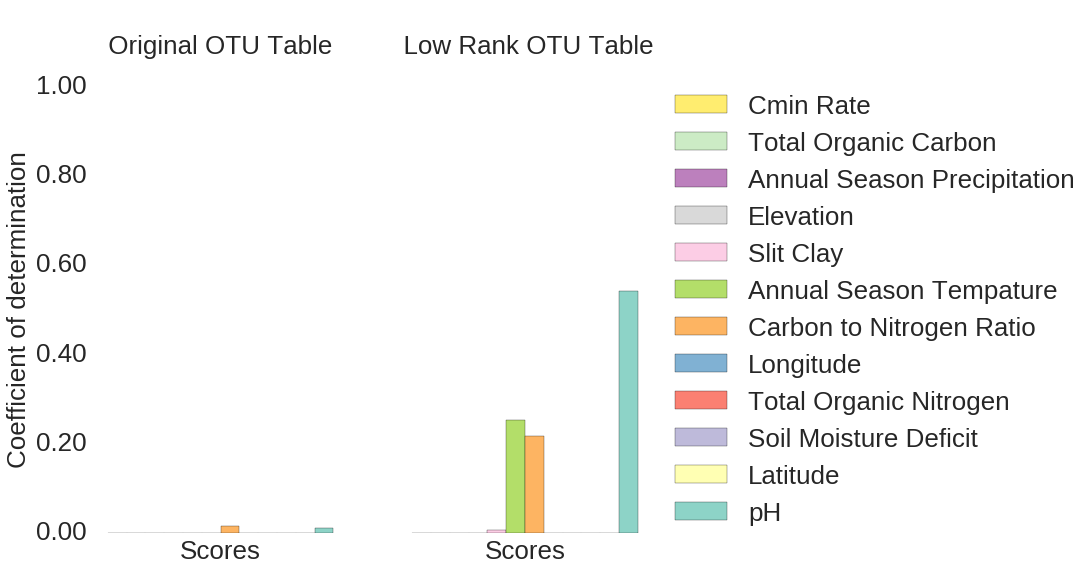

time: 734 ms


In [21]:

########### Model, Cross-Validate and plot Recall Scores for origonal and low-rank data  #############


classifiers_meta=df.columns.values.tolist()
X =low_rank_matrix.T
sv={}

for metatmp in classifiers_meta[4:]:

    Y=df[metatmp].tolist()
    Y = map(int, Y)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.4, random_state=0)
    pca = PCA(n_components=4)
    pca.fit(X_train)
    X_t_train = pca.transform(X_train)
    X_t_test = pca.transform(X_test)
    clf = svm.SVR()
    clf.fit(X_t_train, y_train)
    sv[metatmp] = clf.score(X_t_test, y_test)
    
########### Model, Cross-Validate and plot Recall Scores for origonal and origonal data  #############

X =data.T
svorg={}

for metatmp in classifiers_meta[4:]:

    Y=df[metatmp].tolist()
    Y = map(int, Y)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.4, random_state=0)
    pca = PCA(n_components=4)
    pca.fit(X_train)
    X_t_train = pca.transform(X_train)
    X_t_test = pca.transform(X_test)
    clf = svm.SVR()
    clf.fit(X_t_train, y_train)
    svorg[metatmp] = clf.score(X_t_test, y_test)

############ Convert dict to dataframe and choose colors ##################################

scores = pd.DataFrame(sv.items())
scores=scores.set_index(scores[0])
scores = scores.drop([0], 1)
scores.columns = ['Scores']
bmap = brewer2mpl.get_map('Set3','qualitative',12,reverse=True)
colors = bmap.mpl_colors
scores2 = pd.DataFrame(svorg.items())
scores2=scores2.set_index(scores2[0])
scores2 = scores2.drop([0], 1)
scores2.columns = ['Scores']

################## plot the scores #######################


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15, 10))
#fig.suptitle('Coefficient of determination for Each Classifier \n\n\n\n', fontsize=28, y=1.08)
scores.T.plot(kind='bar', stacked=False,color=colors,legend=True, ylim=(0,1),figsize=(10, 8), width=4.0,fontsize=26,ax=ax2)
scores2.T.plot(kind='bar',stacked=False,color=colors,legend=False, ylim=(0,1),figsize=(10, 8), width=4.0,fontsize=26,ax=ax1)
ax2.set_yticklabels([])
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size':26})
ax2.set_title('\n  Low Rank OTU Table \n',fontsize= 26) 
ax2.set_axis_bgcolor('white')
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:3.2f}'.format(x) for x in vals])
ax1.set_ylabel("Coefficient of determination",{'size':'26'})
ax1.set_title('\n Original OTU Table \n',fontsize= 26) 
ax1.set_axis_bgcolor('white')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=0)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=0)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.show()

# This not only matches the papers conclustions where this data came from 

http://aem.asm.org/content/75/15/5111.full

# It also makes Biological sense


# Classically PCA cannot be used to determine clustering of data in 16S because PCA is skewed by outliers and can only deal with small I.I.D. Gaussian nosie

<img src="etc/pca_vs_outlier.png">


# Now that we have recovered the low rank data lets view the PCA and PCoA clustering by the classifier we revealed through unsuperised learning pH!

### Unsupervised Learning  (no labels)

<img src="etc/leanring_model.png">

### the way we will cluster - agglomerative 

<img src="etc/clustering.png">

### Structured means we have some prior knowledge, our prior on the clustering is k-nearest neighbors

<img src="etc/effect-of-k.png">



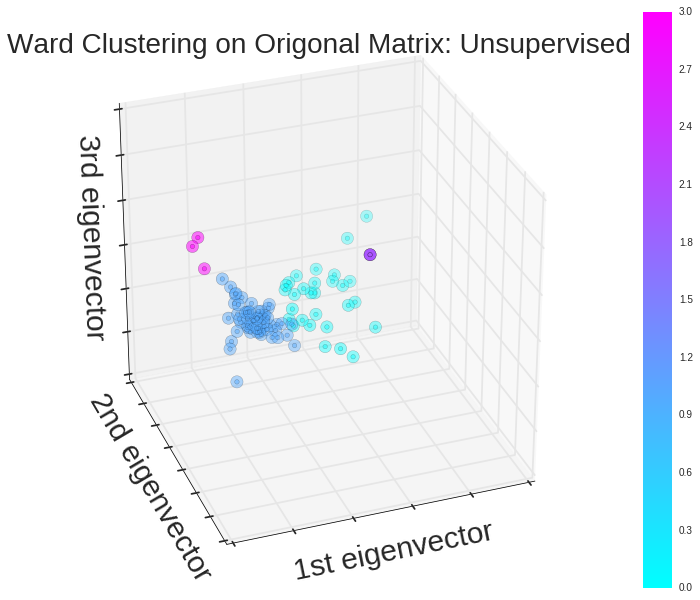

Silhouette Coefficient: 0.151828
Completeness Score: 0.180622
time: 584 ms


In [13]:
########### prigonal data agglomerative clustering #################

X2=data.T
connectivity2 = kneighbors_graph(X2, n_neighbors=10, include_self=False)
ward2 = AgglomerativeClustering(n_clusters=4, connectivity=connectivity2,linkage='ward').fit(X2)
Y_pred = ward2.labels_
Y_true = df['pH'].tolist()
score = completeness_score(Y_pred,Y_true)
silhouette_avg = silhouette_score(X, Y_pred)
fig = plt.figure(2, figsize=(10, 8))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced2 = PCA(n_components=3).fit_transform(X2)
ax.scatter(X_reduced2[:, 0], X_reduced2[:, 1], X_reduced2[:, 2], c=Y_pred,cmap=plt.cm.cool,s=150)
p=ax.scatter(X_reduced2[:, 0], X_reduced2[:, 1], X_reduced2[:, 2], c=Y_pred,cmap=plt.cm.cool)
ax.set_title("Ward Clustering on Origonal Matrix: Unsupervised",fontsize= 28)
ax.set_axis_bgcolor('white')
ax.set_xlabel("1st eigenvector", fontsize=30)
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector", fontsize=30)
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector", fontsize=30)
ax.w_zaxis.set_ticklabels([])
plt.colorbar(p)
plt.show()
print 'Silhouette Coefficient: %f'%silhouette_avg
print 'Completeness Score: %f'%score

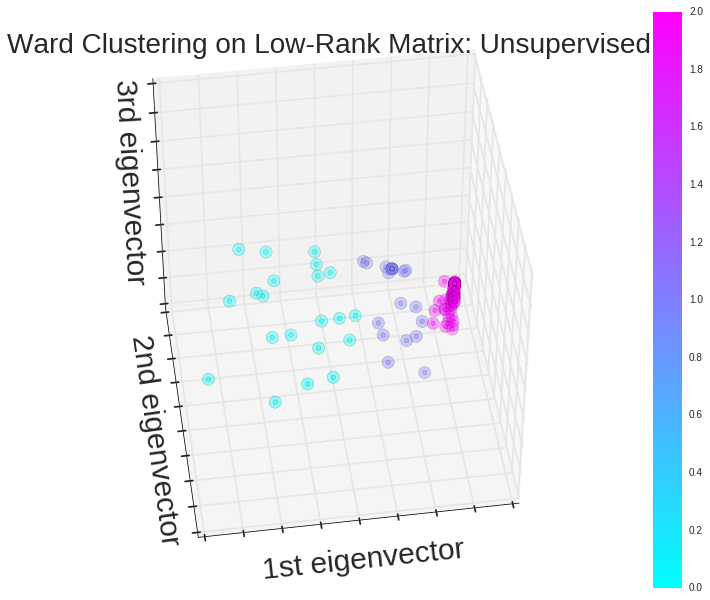

Silhouette Coefficient: 0.655908
Completeness Score: 0.210008
time: 484 ms


In [14]:
########### low rank agglomerative clustering #################
X =low_rank_matrix.T
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
ward = AgglomerativeClustering(n_clusters=3, connectivity=connectivity,linkage='ward').fit(X)
Y_pred = ward.labels_
Y_true = df['pH'].tolist()
score = completeness_score(Y_pred,Y_true)
silhouette_avg = silhouette_score(X, Y_pred)
fig = plt.figure(2, figsize=(10, 8))
ax = Axes3D(fig, elev=-135, azim=278)
X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y_pred,cmap=plt.cm.cool,s=150)
p=ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y_pred,cmap=plt.cm.cool)
ax.set_title("Ward Clustering on Low-Rank Matrix: Unsupervised",fontsize= 28)
ax.set_xlabel("1st eigenvector", fontsize=30)
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector", fontsize=30)
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector", fontsize=30)
ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')
plt.colorbar(p)
plt.show()
print 'Silhouette Coefficient: %f'%silhouette_avg
print 'Completeness Score: %f'%score

# Now we can compare this to the labeled PCA using pH as a label

##### Origonal OTU table

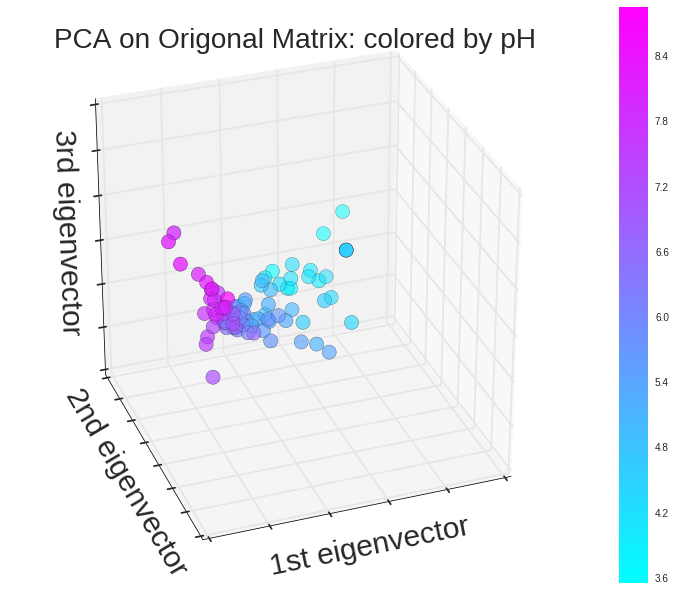

time: 426 ms


In [15]:
%matplotlib inline
Y=df['pH'].tolist()
X =data.T
fig = plt.figure(2, figsize=(10, 8))
ax = Axes3D(fig,elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,cmap=plt.cm.cool,s=200)
p=ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,cmap=plt.cm.cool,s=200)
ax.set_title("PCA on Origonal Matrix: colored by pH",fontsize= 28)
ax.set_axis_bgcolor('white')
ax.set_xlabel("1st eigenvector", fontsize=30)
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector", fontsize=30)
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector", fontsize=30)
ax.w_zaxis.set_ticklabels([])
plt.colorbar(p)
plt.show()

##### Low Rank OTU table


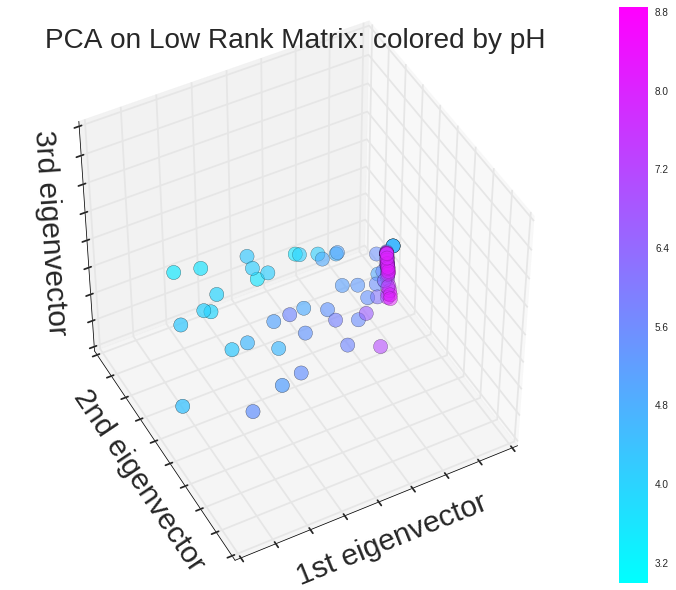

time: 378 ms


In [16]:
Y=df['pH'].tolist()
X =low_rank_matrix.T
fig = plt.figure(2, figsize=(10, 8),dpi=600)
ax = Axes3D(fig, elev=-135, azim=298)
X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,cmap=plt.cm.cool,s=200,vmin=3)
p=ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,cmap=plt.cm.cool,s=200,vmin=3)
ax.set_title("PCA on Low Rank Matrix: colored by pH",fontsize= 28)
ax.set_xlabel("1st eigenvector", fontsize=30)
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector", fontsize=30)
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector", fontsize=30)
ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')
plt.colorbar(p)
plt.show()

# As expected the PCA only works on the Low Rank OTU table, the origonal table did not cluster nicely

# Lets explore further why PCA is great

# Recovering information about features from PCA eigenvectors  

### The priniple components are a linear combination of origonal features in N dimentional space

### $ PC^{j} = \beta_{1}^{j}X_{1} +  \beta_{2}^{j}X_{2} + ... + \beta_{N}^{j}X_{N} $

#### Where $\beta_{N}^{j}$ are wieghts and $X_{N}$ is the origonal variables

#### Therefore the coefficients are the transfrom of an idenity matrix of shape X

#### Each column of the transformed coefficient matrix are the coefficients $\beta_{N}^{j}$ weights pertaining to each principal component $ PC^{j}$. 

#### In other words we can examine the weights on each OTU or bacteria that best explain the variance of each axis in our PCA graph. 


/home/cameron/anaconda2/envs/RPCA_env/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


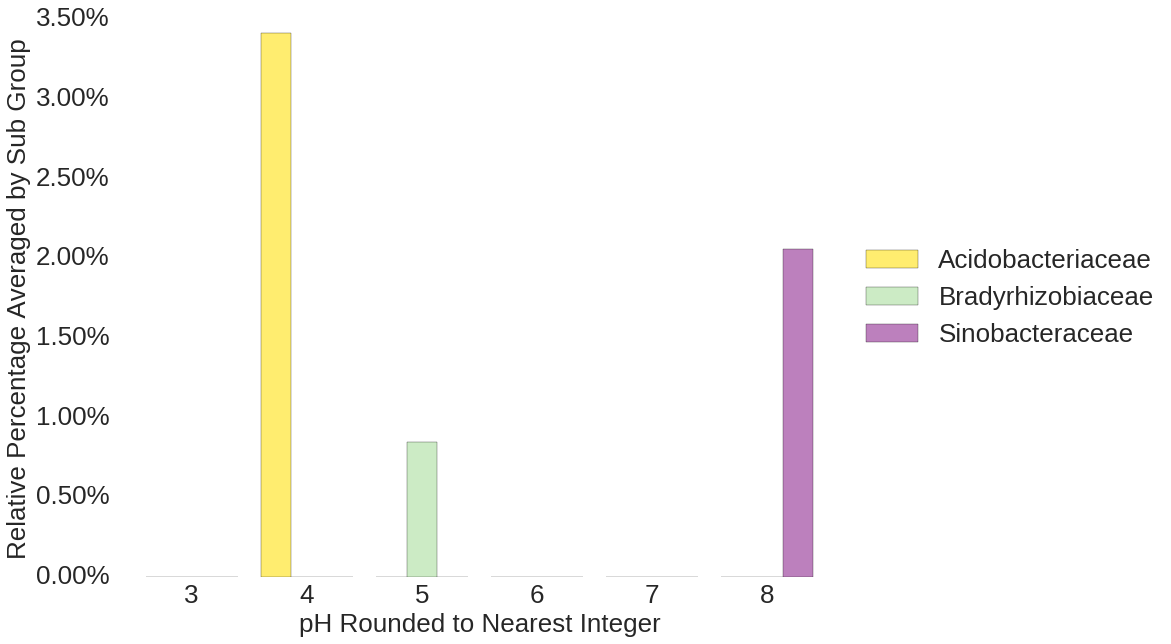

time: 551 ms


In [54]:
# PCA
pca = PCA(n_components=3)

pca.fit_transform(save_lowrankdf.T)

# Dump components relations with features:

df2 = pd.DataFrame(pca.components_,columns=save_lowrankdf.T.columns,index = ['PC-1','PC-2','PC-3']).T
df2.abs()
df2.sort(['PC-1'], ascending = [True], inplace = True)
bact_list = df2.index.values.tolist()
check='start'

bactandotu=otu
for n in bactandotu.columns.values.tolist():
    if n != 'bact_id':
        wtemp = ((100/(bactandotu["%s"%n].sum()))*100)
        bactandotu['%s'%n] = bactandotu['%s'%n] *wtemp



for bact in bact_list[:12]:
    if check=='start':
        def3=bactandotu.T[bact]
        def3.sum(axis=1)
        def2=def3.T[-1:]
        def2=def2.T
        def2['Sub Groups in PCA'] = df['Description']
        def2=def2.groupby('Sub Groups in PCA', as_index=False).mean()
        def2 = def2.set_index('Sub Groups in PCA')
        check='not-start'
    else:
        def3tmp=bactandotu.T[bact]
        def3tmp.sum(axis=1)
        def2tmp=def3tmp.T[-1:]
        def2tmp=def2tmp.T
        def2tmp['Sub Groups in PCA'] = df['Description']
        def2tmp=def2tmp.groupby('Sub Groups in PCA', as_index=False).mean()
        def2tmp = def2tmp.set_index('Sub Groups in PCA')
        def2 = pd.concat([def2, def2tmp], axis=1, join='inner')
    

for ln in def2.columns.values.tolist():
    if ln=='k__Bacteriaf__':
        def2=def2.drop(ln, 1)

def2=def2.T
def2=def2.groupby(def2.index).sum()
def2=def2.T 
def2['k__Bacteriaf__Acidobacteriaceae'] = def2['k__Bacteriaf__Acidobacteriaceae'] + def2['k__Bacteriaf__Koribacteraceae']  #rename koribacteraceae to real name 
def2=def2.drop('k__Bacteriaf__Koribacteraceae', 1)
def2.rename(columns={'k__Bacteriaf__Acidobacteriaceae': 'Acidobacteriaceae', 'k__Bacteriaf__Bradyrhizobiaceae': 'Bradyrhizobiaceae', 'k__Bacteriaf__Sinobacteraceae': 'Sinobacteraceae'}, inplace=True)


fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(36, 10))
bmap = brewer2mpl.get_map('Set3','qualitative',12,reverse=True)
colors = bmap.mpl_colors
def2.plot(kind='bar', stacked=False,color=colors,legend=True, width=.80, figsize=(13, 10),fontsize=26,ax=ax1)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size':26})
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=360)
ax1.tick_params(axis='y', labelsize=26)
vals = ax1.get_yticks()
ax1.set_axis_bgcolor('white')
ax1.set_yticklabels(['{:3.2f}%'.format(x) for x in vals])
ax1.set_ylabel("Relative Percentage Averaged by Sub Group",{'size':'26'})
ax1.set_xlabel("pH Rounded to Nearest Integer",{'size':'26'})
plt.show()

## The Bacteria with the highest variance between pH clusters by multivariate weights make sense because they belong to the families Bradyrhizobiaceae, Sinobacteraceae and Acidobacteriaceae. All of which have members that are described to grow at pH as low as 3 (B. elkanii (Jordan, 1982) and A. capsulatum (Hrash and Coates, 2011)), and pH 5 (S. flavus (Zhou et al., 2008)).

# We can confirm this using the more conventional PCoA on the origonal data

# PCoA on Origonal OTU table

anosim results:
Method name  Sample size  Number of groups     R statistic  p-value  Number of permutations
     ANOSIM           89                77  0.558211905982    0.001                     999



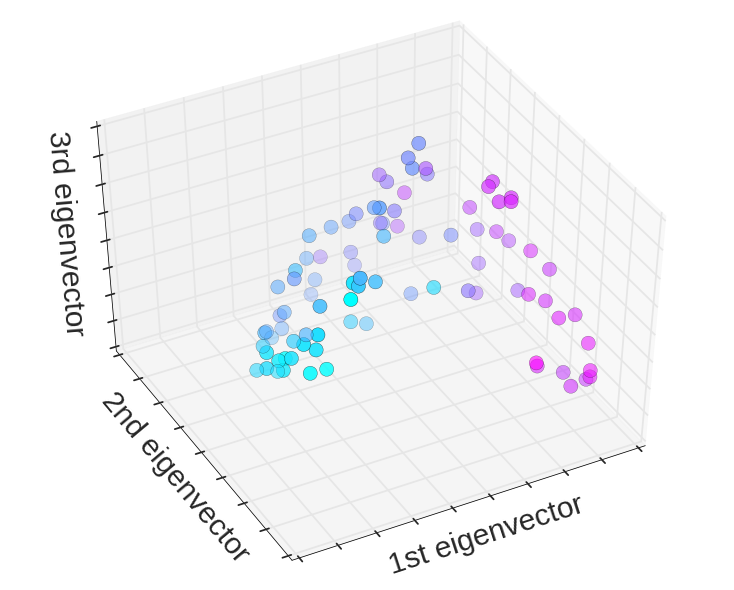

time: 1.7 s


In [45]:

############### Calculate PCoA ##########################################

df2= pd.read_table('data/soil_map.txt', index_col=0)
df2.index = df.index.map(str)
all_dm = pw_distances(rpcadata.T, ids, "braycurtis")
all_dm_pc = PCoA(all_dm).scores()
df3= df2.T
samplenames = df3.ix[2,:].tolist()
samplenames = map(str, samplenames)
dflist = list(df2.columns.values)
remove = 0, 1, 2, 3
labels = [i for j, i in enumerate(dflist) if j not in remove]
df3=df2.T
Descript = df3.ix[3,:].tolist()
deslist=[]
for hcek in Descript:
    if hcek not in deslist:
        deslist.append(hcek)
    if hcek in deslist:
        continue

        
bmap1 = brewer2mpl.get_map('Set1','qualitative',5,reverse=True)
bmap2 = brewer2mpl.get_map('Dark2','qualitative',8,reverse=True)
colors1 = bmap1.mpl_colors
colors2 = bmap2.mpl_colors
colors=colors1+colors2
dictionary_legnd = dict(zip(deslist, colors))
fig1 = scatter_3d(all_dm_pc, df, 'pH', dictionary_legnd)
plt.savefig('/home/cameron/fix_typo/pcoa_chrohn.png',transparent=True, dpi=300)


anosim = ANOSIM(all_dm, df, column='pH')
results = anosim(999)
print "anosim results:"
print results

# As a final conformation we can see how the PCoA graph looks on the origonal data using pH as a classifier

# As expected the PCoA clearly shows that pH is a good classifier

# We can view this by sorting the samples in the the data by thie pH from high to low as well

In [46]:
plt.close('all')

time: 1.03 ms
